## Create non IID dataset with irregularly sampled timestamps

Test script, to be integrated in main pipeline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lib.generate_timeseries import Periodic_1d
import torch
from collections import Counter
from matplotlib import cm
from torch.distributions import uniform
import pandas as pd
import seaborn as sns
import sys
import json
import glob
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
# Ensure seaborn theme
sns.set(style='whitegrid')
from lib.dataset_utils import *
%matplotlib inline
# automatic reload
%load_ext autoreload
%autoreload 2


def read_loss_file(file):
    # Read the meta.csv file
    meta_file = file.replace("results.json", "meta.csv")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    batch_size = meta_data['batch_size'].item()
    clipping = meta_data['gradientclipping'].item()
    lrdecay = meta_data['lrdecay'].item()
    nlocalepochs = meta_data['localepochs'].item()
    
    # Read the results.json file
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Plot centralized evaluate
    df_centralized_evaluate = pd.DataFrame(data['centralized_evaluate'])
    df_federated_evaluate = pd.DataFrame(data['federated_evaluate'])
    df_aggregation = pd.DataFrame(data['aggregation'])
    # Add the learning rate to the DataFrame
    df_federated_evaluate['lr'] = lr
    df_centralized_evaluate['lr'] = lr
    # Add the batch size to the DataFrame
    df_federated_evaluate['batch_size'] = batch_size
    df_centralized_evaluate['batch_size'] = batch_size
    # Add the clipping to the DataFrame
    df_federated_evaluate['clipping'] = clipping
    df_centralized_evaluate['clipping'] = clipping
    # add decay
    df_federated_evaluate['lrdecay'] = lrdecay
    df_centralized_evaluate['lrdecay'] = lrdecay
    # add nlocalepochs
    df_federated_evaluate['localepochs'] = nlocalepochs
    df_centralized_evaluate['localepochs'] = nlocalepochs
    # add decay onset 
    df_federated_evaluate['decay_onset'] = meta_data['decay_onset'].item()
    df_centralized_evaluate['decay_onset'] = meta_data['decay_onset'].item()
    # add datasetname
    df_federated_evaluate['dataset_name'] = meta_data['dataset_name'].item()
    df_centralized_evaluate['dataset_name'] = meta_data['dataset_name'].item()
    # TODO clean 
    # extrat the last part of the dataset name
    df_federated_evaluate['offset'] = df_federated_evaluate['dataset_name'].apply(lambda x: x.split('_')[-1])
    df_centralized_evaluate['offset'] = df_centralized_evaluate['dataset_name'].apply(lambda x: x.split('_')[-1])
    # make it float
    df_federated_evaluate['offset'] = df_federated_evaluate['offset'].astype(float)
    df_centralized_evaluate['offset'] = df_centralized_evaluate['offset'].astype(float)

    # alpha
    df_federated_evaluate['alpha'] = meta_data['alpha'].item()
    df_centralized_evaluate['alpha'] = meta_data['alpha'].item()

    # Aggregation column 
    # Check if file contins "FedAvg" in the path name
    if "FedAvg" in file:
        # if the path name contains "FedAvg" then add aggregation column "FedAvg"
        df_federated_evaluate['aggregation'] = "FedAvg"
        df_centralized_evaluate['aggregation'] = "FedAvg"
    else:
        # if the path name does not contain "FedAvg" then add aggregation column "FedProx"
        df_federated_evaluate['aggregation'] = "FedODE"
        df_centralized_evaluate['aggregation'] = "FedODE"

    # if the path name contains "FedAvg" then add aggregation column "FedAvg"
    df_federated_evaluate['hyperparameters'] = df_federated_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}, lrdecay: {x['lrdecay']}, nlocalepochs: {x['localepochs']}", axis=1)
    df_centralized_evaluate['hyperparameters'] = df_centralized_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}, lrdecay: {x['lrdecay']}, nlocalepochs: {x['localepochs']}", axis=1)
    # combine lr, batch size and clipping into one column

    df_federated_evaluate['type'] = "federated"
    df_centralized_evaluate['type'] = "centralized"

    # modify centralized_loss into loss
    df_centralized_evaluate.rename(columns={'centralized_loss': 'loss'}, inplace=True)
    # modify federated_loss into loss
    df_federated_evaluate.rename(columns={'federated_evaluate_loss': 'loss'}, inplace=True)

    return df_centralized_evaluate, df_federated_evaluate, df_aggregation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
####################################
# Data generation
#####################################

path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "timestamps"

n_clients = 2
n_samples_per_client = 2  # number of samples per client

amp = 1.0
freq =0.5
noise_weight = 0
n_total_tp = None

n_samples_per_combination = 10
# instruction for the time steps sampling
distribution = "beta"
n_total_tp = 100
max_t = 5
time_steps = None
n = 10 
# Generate data for first client
dataset, timesteps = get_dataset(amp, freq, timesteps = time_steps, noise_weight=noise_weight, n_samples=n, n_total_tp=n_total_tp, max_t=max_t, distribution = distribution)
amps = np.full((dataset.shape[0],), amp)
freqs = np.full((dataset.shape[0],), freq)
full_dataset = amps, freqs, dataset, timesteps
train, test = split_train_test_with_meta(full_dataset, train_fraq = 0.8)
dataset_prefix = f"{prefix}_beta"
store_dataset(train, test, dataset_prefix=dataset_prefix, path_prefix=path_prefix, client_prefix=f"client_0")


# Generate data for first client
dataset, timesteps = get_dataset(amp, freq, timesteps = time_steps, noise_weight=noise_weight, n_samples=n, n_total_tp=n_total_tp, max_t=max_t, distribution = distribution)
amps = np.full((dataset.shape[0],), amp)
freqs = np.full((dataset.shape[0],), freq)
full_dataset = amps, freqs, dataset, timesteps
train, test = split_train_test_with_meta(full_dataset, train_fraq = 0.8)
dataset_prefix = f"{prefix}_beta"
store_dataset(train, test, dataset_prefix=dataset_prefix, path_prefix=path_prefix, client_prefix=f"client_1")


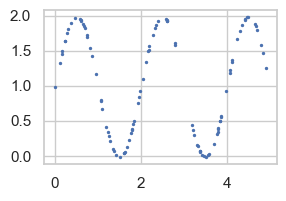

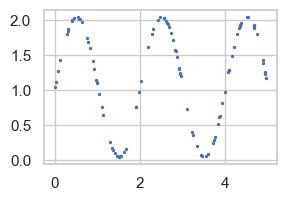

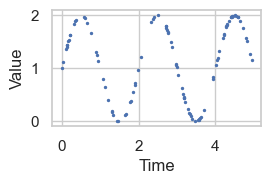

In [20]:
for i in range(3):
    #plt.plot(timesteps[i], data[i], label=f"Amp: {amp[i]:.2f}, Freq: {freq[i]:.2f}")
    plt.figure(figsize=(3, 2))
    plt.scatter(train["time_steps"][i], train["data"][i], s=2, alpha=1)

plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

Loading data from ../data/noise_one_noise_0.0/client_0_train.pt with max frequency 0.0...


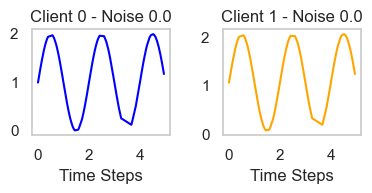

Loading data from ../data/noise_one_noise_0.5/client_0_train.pt with max frequency 0.5...


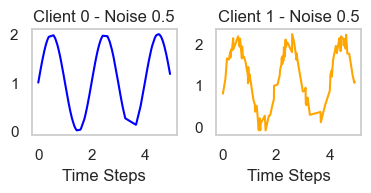

Loading data from ../data/noise_one_noise_1.0/client_0_train.pt with max frequency 1.0...


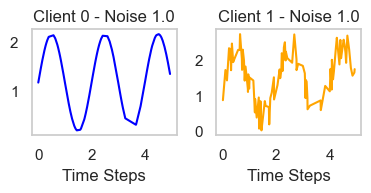

Loading data from ../data/noise_one_noise_1.5/client_0_train.pt with max frequency 1.5...


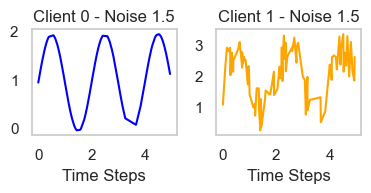

Loading data from ../data/noise_one_noise_2.0/client_0_train.pt with max frequency 2.0...


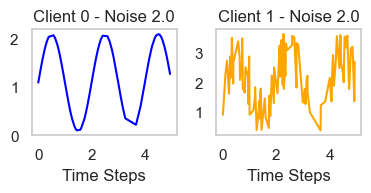

Loading data from ../data/noise_one_noise_2.5/client_0_train.pt with max frequency 2.5...


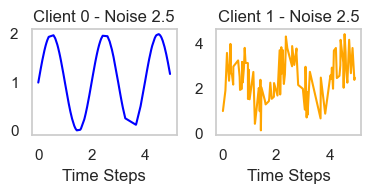

Loading data from ../data/noise_one_noise_3.0/client_0_train.pt with max frequency 3.0...


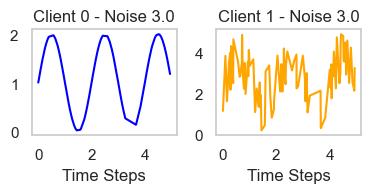

In [26]:
dataset_prefix = f"noise_one*"
data_folder = "../data/"
data_files = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_0_train.pt"))

# sort files by max frequency
data_files.sort(key=lambda x: float(x.split("noise_")[-1].split("_")[0].split("/")[0]))
# Load and plot the dat


for file in data_files:
    # max frequency is encoded in the filename
    noise = float(file.split("noise_")[-1].split("_")[0].split("/")[0])
    print(f"Loading data from {file} with max frequency {noise}...")

    training_data = torch.load(file, weights_only=True)
    time_steps= torch.load(file.replace("train", "time_steps_train"), weights_only=True)

    y = training_data[0].squeeze()
    x = time_steps[0].squeeze()

    # Plot the data
    plt.figure(figsize=(4, 2.1))
    # make it 2 next to each other
    plt.subplot(1, 2, 1)
    plt.plot(x, y, label=f"Client 0 - Noise {noise}", color='blue')
    plt.title(f"Client 0 - Noise {noise}")
    plt.xlabel("Time Steps")
    plt.grid()
    plt.subplot(1, 2, 2)
    client_1 = file.replace("client_0", "client_1")
    y_1 = torch.load(client_1, weights_only=True)[0].squeeze()
    x_1 = torch.load(client_1.replace("train", "time_steps_train"), weights_only=True)[0].squeeze()
    plt.plot(x_1, y_1, label=f"Client 1 - Noise {noise}", color='orange')
    plt.title(f"Client 1 - Noise {noise}")
    plt.xlabel("Time Steps")
    plt.grid()
    plt.tight_layout()
    plt.show()


## Plot the results

In [160]:

result_json = glob.glob(f"../results_small/**/federated_training/**/2_rounds/**/results.json", recursive=True)

start_freq = 0.1
df_summary_centralized = pd.DataFrame()
df_summary_federated = pd.DataFrame()
df_summary_aggregation = pd.DataFrame()
for file in result_json:
    # max frequency is encoded in the filename
    max_freq = float(file.split("maxfreq_")[-1].split("_")[0].split("/")[0])
    difference = max_freq - start_freq
    df_centralized_evaluate, df_federated_evaluate, df_aggregation = read_loss_file(file)
    df_centralized_evaluate['max_freq'] = max_freq
    df_centralized_evaluate['difference'] = difference
    df_summary_centralized = pd.concat([df_summary_centralized, df_centralized_evaluate], ignore_index=True)
    df_federated_evaluate['max_freq'] = max_freq
    df_federated_evaluate['difference'] = difference
    df_summary_federated = pd.concat([df_summary_federated, df_federated_evaluate], ignore_index=True)
    df_aggregation['max_freq'] = max_freq
    df_aggregation['difference'] = difference
    df_summary_aggregation = pd.concat([df_summary_aggregation, df_aggregation], ignore_index=True)
    print(f"Processing results for max frequency {max_freq} with difference {difference}...")




Processing results for max frequency 0.15 with difference 0.04999999999999999...
Processing results for max frequency 0.2 with difference 0.1...
Processing results for max frequency 0.1 with difference 0.0...
Processing results for max frequency 0.35 with difference 0.24999999999999997...


<Figure size 1000x300 with 0 Axes>

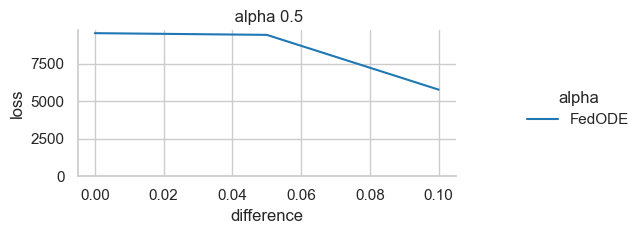

In [105]:
######################################
#  Plot the last loss vs difference
#######################################
df_summary_centralized_last = df_summary_centralized[df_summary_centralized["round"] == 2]
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_centralized_last,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='difference',
    y='loss',
    hue='aggregation',
    palette='tab10'
)

# Adjustments
g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))



# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()


Processing file ../results_small/freq_steps_maxfreq_0.15/federated_training/FedODE/2_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_64_clipping_False_lrdecay_1.0_localepochs_1_decayonset_15_alpha_0.5/federated_outputs/results.json...
Max frequency: 0.15
Processing file ../results_small/freq_steps_maxfreq_0.2/federated_training/FedODE/2_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_64_clipping_False_lrdecay_1.0_localepochs_1_decayonset_15_alpha_0.5/federated_outputs/results.json...
Max frequency: 0.2
Processing file ../results_small/freq_steps_maxfreq_0.1/federated_training/FedODE/2_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_64_clipping_False_lrdecay_1.0_localepochs_1_decayonset_15_alpha_0.5/federated_outputs/results.json...
Max frequency: 0.1
Processing file ../results_small/freq_steps_maxfreq_0.35/federated_training/FedODE/2_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_64_clipping_False_lrdecay_1.0_localepochs_1_decayonset_15_alpha_0.5/federated_outputs/results.json...
Max frequency: 0.35


<Figure size 1000x300 with 0 Axes>

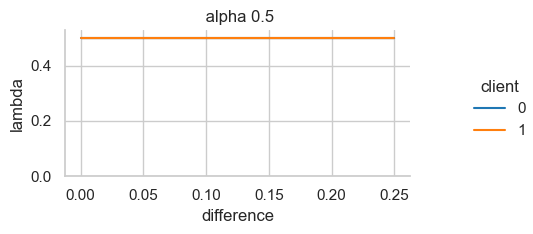

In [161]:
######################################
#  Plot the lambdas vs difference
#######################################
df_summary = pd.DataFrame()
for file in result_json:
    print(f"Processing file {file}...")
    # maxfreq find anything with maxfreq_ in the filename and extract what is after the _
    max_freq = float(file.split("maxfreq_")[-1].split("_")[0].split("/")[0])
    print(f"Max frequency: {max_freq}")
    difference = max_freq - start_freq
    df_centralized_evaluate_temp, df_federated_evaluate_temp, df_aggregation_temp = read_loss_file(file)
    # merge by round
    df_summary_temp = pd.concat([df_centralized_evaluate_temp, df_federated_evaluate_temp])
    # merge df aggregation by round
    df_aggregation_temp['round'] = df_aggregation_temp['round'].astype(int)
    df_summary_temp = df_summary_temp.merge(df_aggregation_temp, on=['round', "alpha"], how='left')
    df_summary_temp['max_freq'] = max_freq
    df_summary_temp['difference'] = difference
    df_summary = pd.concat([df_summary, df_summary_temp])

    # add df_aggregation to df_summary
# remove round 0 
df_summary[['round', 'loss', 'aggregation', 'alpha', 'max_freq', 'difference']]

# from df summary print x the rounds and y the lambdas 
df_summary['round'] = df_summary['round'].astype(int)
df_summary = df_summary[df_summary['round'] > 0]  # filter out round 0
# explode lambdas 
# lambdas contains a vector 
# take out the 2 lambdas and put them in a new column called lambda and a new column called client and containig 0 or 1\
df_summary['lambda_0'] = df_summary['lambdas'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df_summary['lambda_1'] = df_summary['lambdas'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)
df0 = df_summary[['round', 'difference', 'lambda_0', 'aggregation', 'alpha']].copy()
df0['client'] = 0
df0 = df0.rename(columns={'lambda_0': 'lambda'})
df1 = df_summary[['round', 'difference', 'lambda_1', 'aggregation', 'alpha']].copy()
df1.rename(columns={'lambda_1': 'lambda'}, inplace=True)
df1['client'] = 1
df_summary_lambdas = pd.concat([df0, df1], ignore_index=True)


# ensure round is int
# plot
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_lambdas,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='difference',
    y='lambda',
    hue="client",
    palette='tab10'
)

# Adjustments
g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))



# Move legend outside
g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()